# Bistability and optimisation analysis

## RFP case

Script used to compare the OED (RFP case) reults to randomly picked single step experiments.
   ............................................................................................................................................................................................................................................

### Import Required libraries

In [1]:
# Common python libraries
import numpy as np
# from scipy.integrate import odeint
# from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# import scipy
import pandas as pd
# import seaborn as sns
import pickle
# import math

# Gaussian Process Fitting Scripts
import gaussianprocess as gp
# from fitderiv import fitderiv
# import genutils as gu
# import datetime

# Bayesian Optimisation Scripts
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

# Avoid unnecessary warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Multiprocessing
from multiprocessing import Pool
import multiprocessing as mp

# Functions with Models compyled with Cython
# import Model1_Cython as M1
# import Model2_Cython as M2
# import Model3_Cython as M3

# Function to simulate the 3 models for all parameter draws (needed in separate file for multiprocessesing in windows)
import SolveALLCy as SAC

# Bhattacharyya Distance Function 
import BhattacharyyaDistanceV1 as BD

import seaborn as sns
import matplotlib.ticker
import matplotlib.gridspec as gridspec

## Utility Functions

In [2]:
def utility1 (IPTG1,
             aTc1):
    
    # Definition of inputs for the ODEs
        
    inputs = [round(IPTG1,2)+1e-7, int(aTc1)+1e-7]
    
    # Initial values for steady state and inputs
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(24*60),2))]
    t =  np.linspace(0,(24*60),(24*60)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
#     solM1 = SAC.solveALLCy2(t, pM1, sp, inputs, ivss, pre, 'M1')
#     solM2 = SAC.solveALLCy2(t, pM2, sp, inputs, ivss, pre, 'M2')
    if __name__ ==  '__main__': 
        num_processors = mp.cpu_count()
        p=Pool(processes = num_processors)
        for i in range(0,2):
            if i==0:
                r1 = p.apply_async(SAC.solveALLCy2, args=(t, pM1, sp, inputs, ivss, pre, 'M1'))
            elif i==1:
                r2 = p.apply_async(SAC.solveALLCy2, args=(t, pM2, sp, inputs, ivss, pre, 'M2'))
        
        p.close()
        p.join() 
    
    solM1 = r1.get()
    solM2 = r2.get()    
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(24*60),round(24*60/5)+1)
    
    muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2.std(axis = 1)
    muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
    sdG3 = GFP_M2.std(axis = 1)
    muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1.std(axis = 1)
    muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
    sdG2 = GFP_M1.std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
#     gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
#     gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
#     gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
#     gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
#     gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
#     gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
#     muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
#     tref = list(tgp[::10])

#     g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
#     g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
#     g2G3.predict(tref)

    
#     muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
#     tref = list(tgp[::10])

    
#     g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
#     g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
#     g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BD.BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
#     bdG = BD.BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    if bdR==float('inf'):
        muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::14])
        tref = list(tgp[::14])

        g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2R3.predict(tref)


        muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::14])
        tref = list(tgp[::14])

        g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2R2.predict(tref)
        bdR = BD.BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
#     elif bdG==float('inf'):
#         muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::14])
#         tref = list(tgp[::14])

#         g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
#         g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
#         g2G3.predict(tref)


#         muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::14])
#         tref = list(tgp[::14])


#         g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
#         g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
#         g2G2.predict(tref)
#         bdG = BD.BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
        
    if bdR==float('inf'):
        muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::15])
        tref = list(tgp[::15])

        g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2R3.predict(tref)


        muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::15])
        tref = list(tgp[::15])

        g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2R2.predict(tref)
        bdR = BD.BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)    
    # Utility function value
    u_B = (bdR)

    return(u_B)
    

In [3]:
def utility2 (IPTG1, IPTG2,
             aTc1, aTc2):
    
    # Definition of inputs for the ODEs
        
    inputs = [round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7]
    
    # Initial values for steady state and inputs
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(24*60),3))]
    t =  np.linspace(0,(24*60),(24*60)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
#     solM1 = SAC.solveALLCy2(t, pM1, sp, inputs, ivss, pre, 'M1')
#     solM2 = SAC.solveALLCy2(t, pM2, sp, inputs, ivss, pre, 'M2')
    if __name__ ==  '__main__': 
        num_processors = mp.cpu_count()
        p=Pool(processes = num_processors)
        for i in range(0,2):
            if i==0:
                r1 = p.apply_async(SAC.solveALLCy2, args=(t, pM1, sp, inputs, ivss, pre, 'M1'))
            elif i==1:
                r2 = p.apply_async(SAC.solveALLCy2, args=(t, pM2, sp, inputs, ivss, pre, 'M2'))
        
        p.close()
        p.join() 
    
    solM1 = r1.get()
    solM2 = r2.get()    
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(24*60),round(24*60/5)+1)
    
    muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2.std(axis = 1)
    muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
    sdG3 = GFP_M2.std(axis = 1)
    muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1.std(axis = 1)
    muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
    sdG2 = GFP_M1.std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
#     gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
#     gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
#     gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
#     gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
#     gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
#     gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
#     muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
#     tref = list(tgp[::10])

#     g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
#     g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
#     g2G3.predict(tref)

    
#     muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
#     tref = list(tgp[::10])

    
#     g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
#     g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
#     g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BD.BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
#     bdG = BD.BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    
    # Utility function value
    u_B = (bdR)

    return(u_B)
    

## Random inputs

In [4]:
ranInput = [[round(0.85, 2)+1e-7, int(5)+1e-7], 
            [round(0.10, 2)+1e-7, int(0)+1e-7], 
            [round(0.20, 2)+1e-7, int(50)+1e-7], 
            [round(0.64, 2)+1e-7, int(68)+1e-7], 
            [round(0.80, 2)+1e-7, int(26)+1e-7], 
            [round(0.25, 2)+1e-7, int(11)+1e-7], 
            [round(0.84, 2)+1e-7, int(14)+1e-7], 
            [round(0.38, 2)+1e-7, int(6)+1e-7], 
            [round(0.08, 2)+1e-7, int(1)+1e-7]] 

In [5]:
halfbi = [[round(0.38, 2)+1e-7, int(7)+1e-7], 
            [round(0.41, 2)+1e-7, int(6)+1e-7], 
            [round(0.71, 2)+1e-7, int(13)+1e-7], 
            [round(0.64, 2)+1e-7, int(10)+1e-7]] 

### Simulations

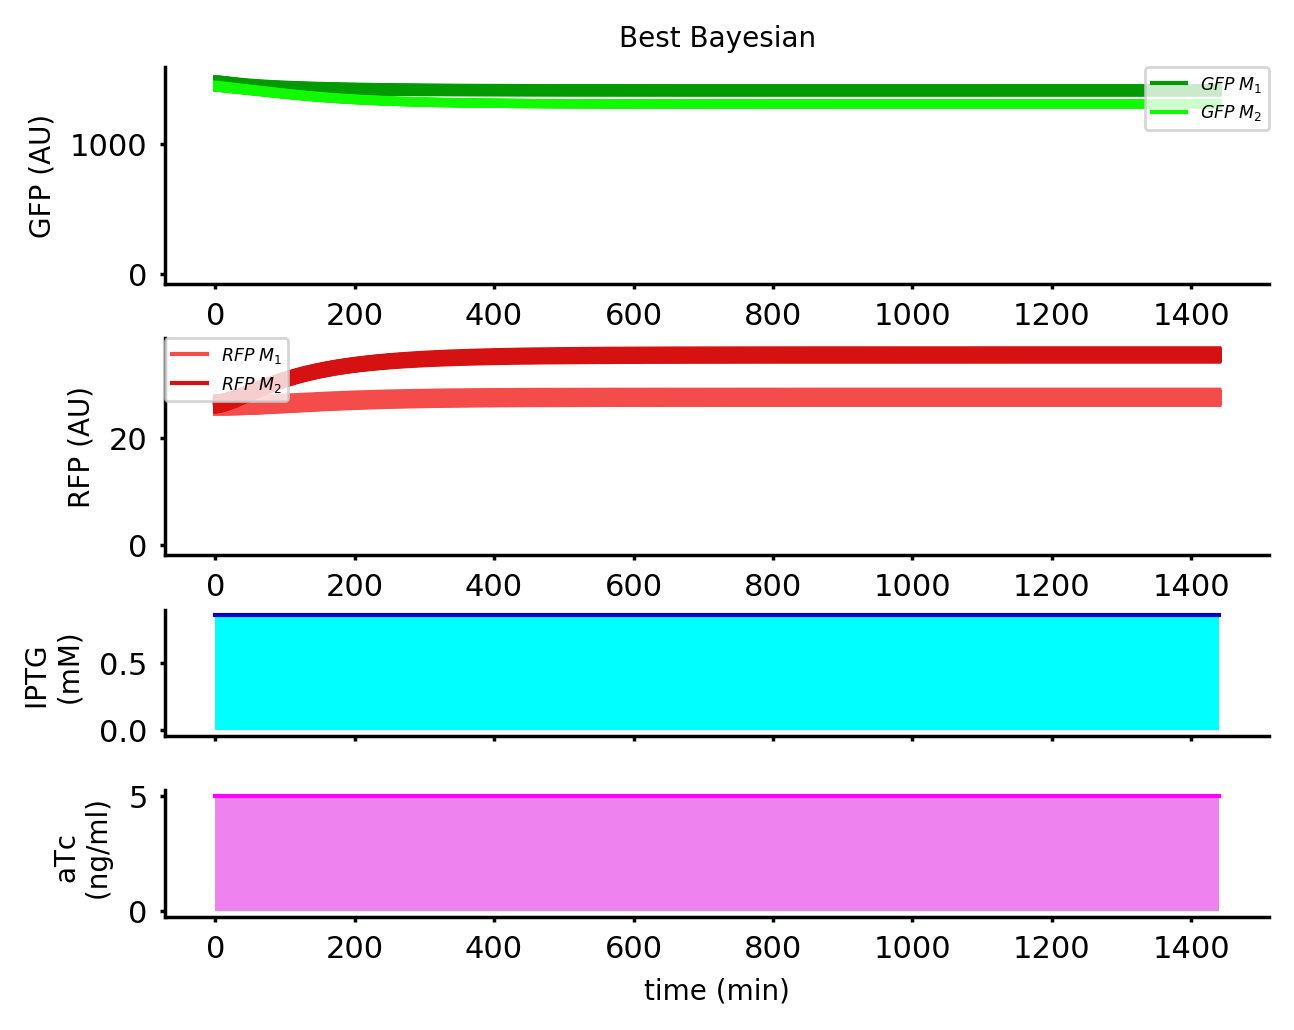

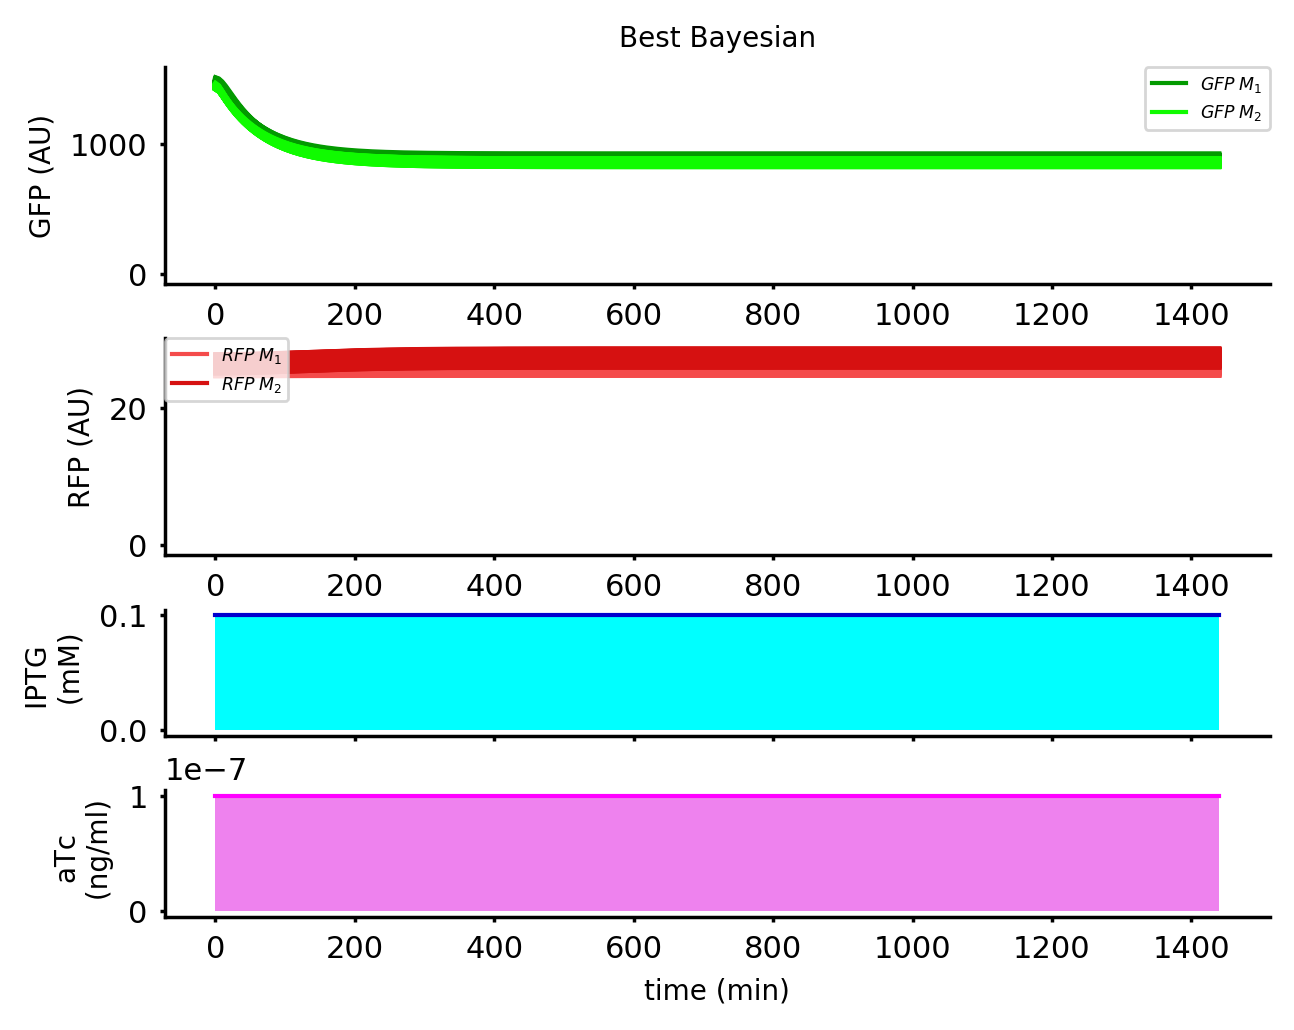

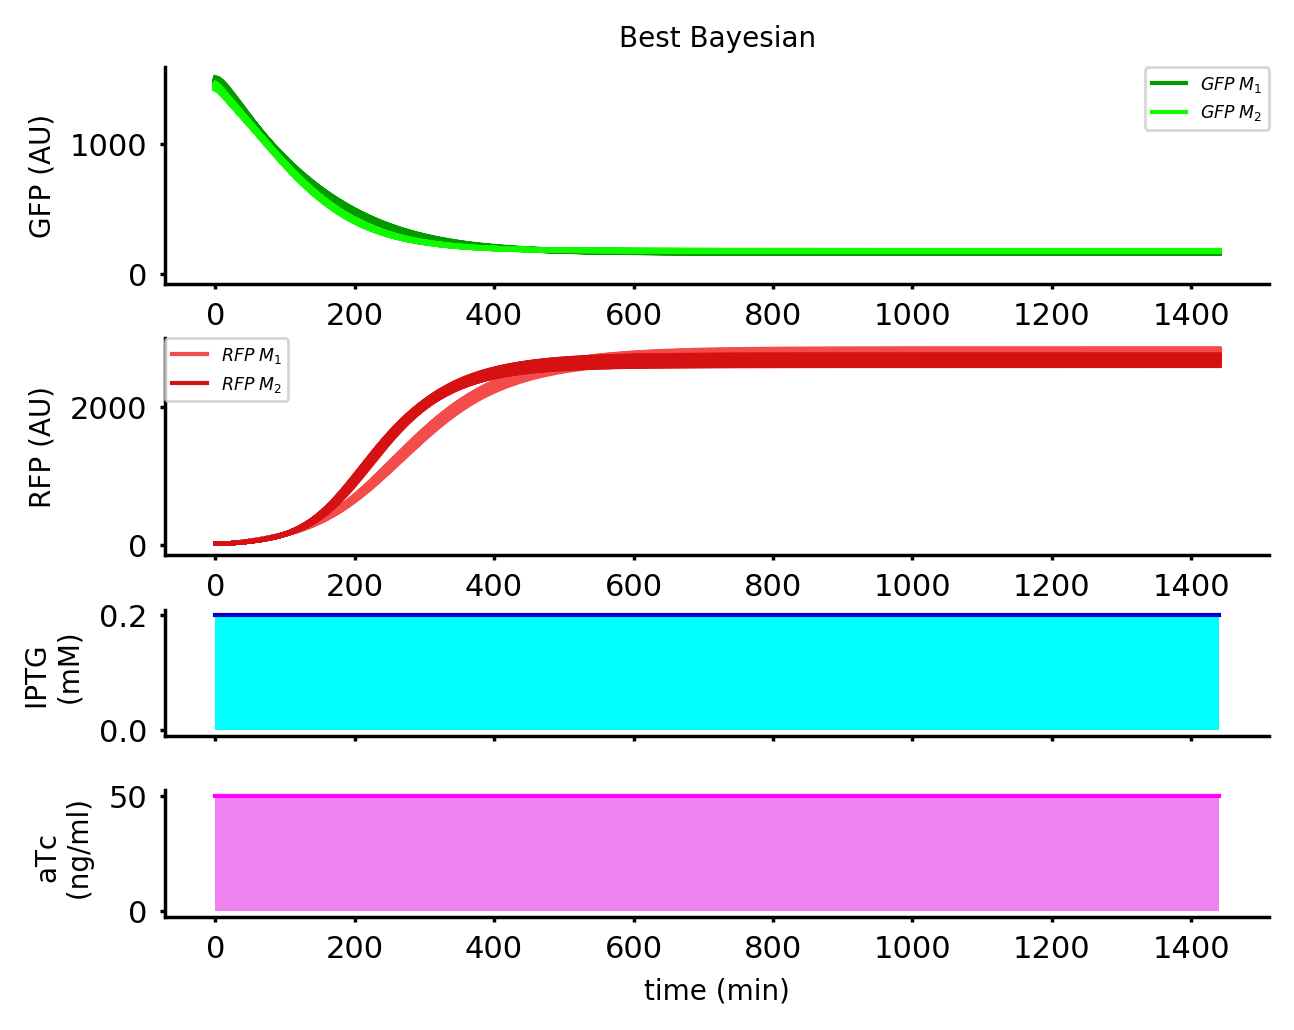

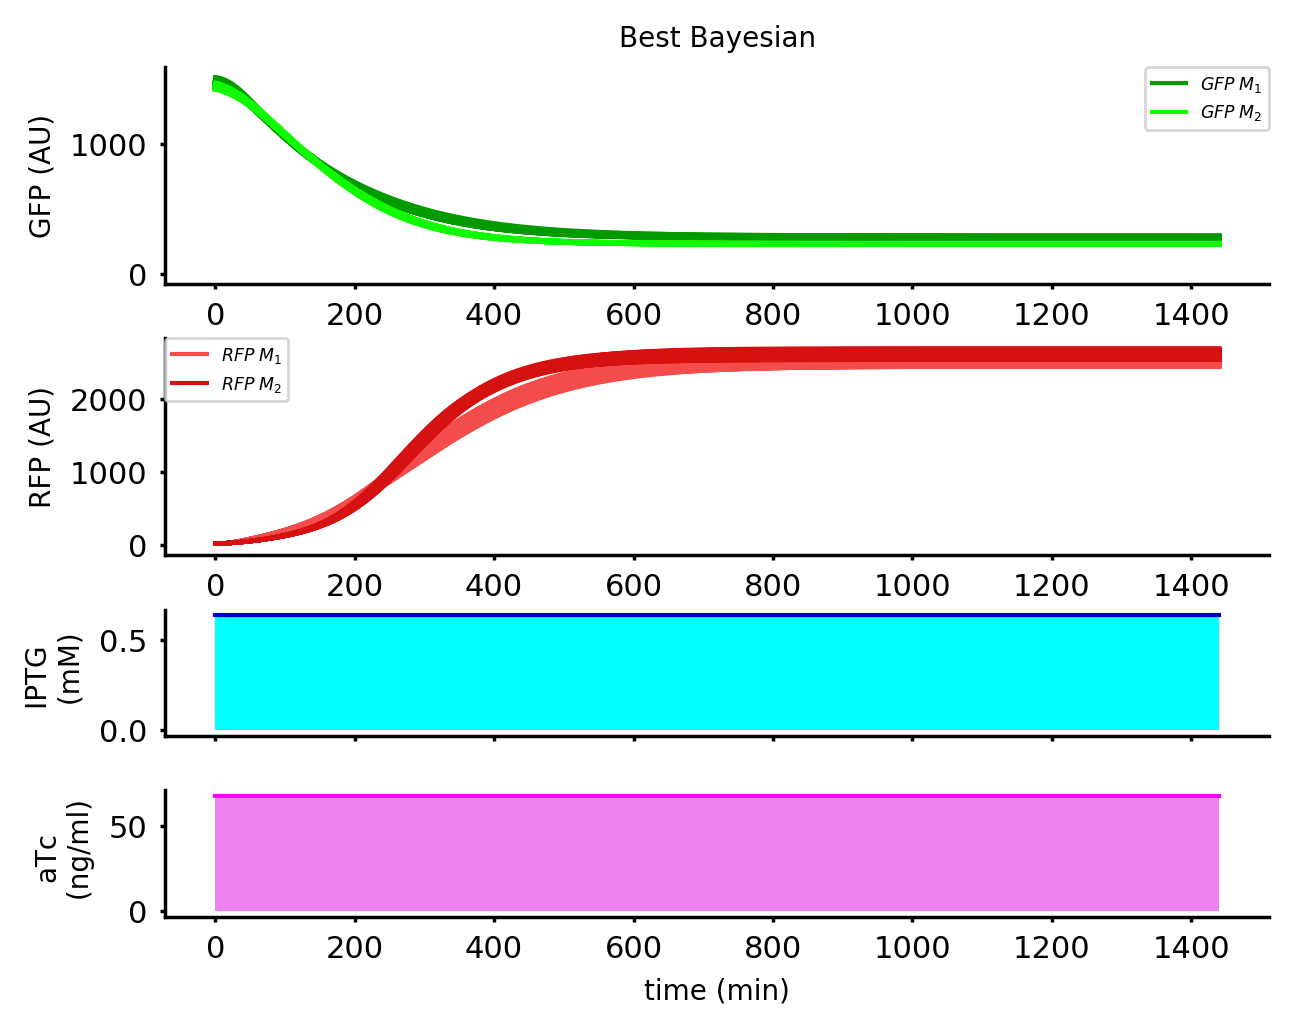

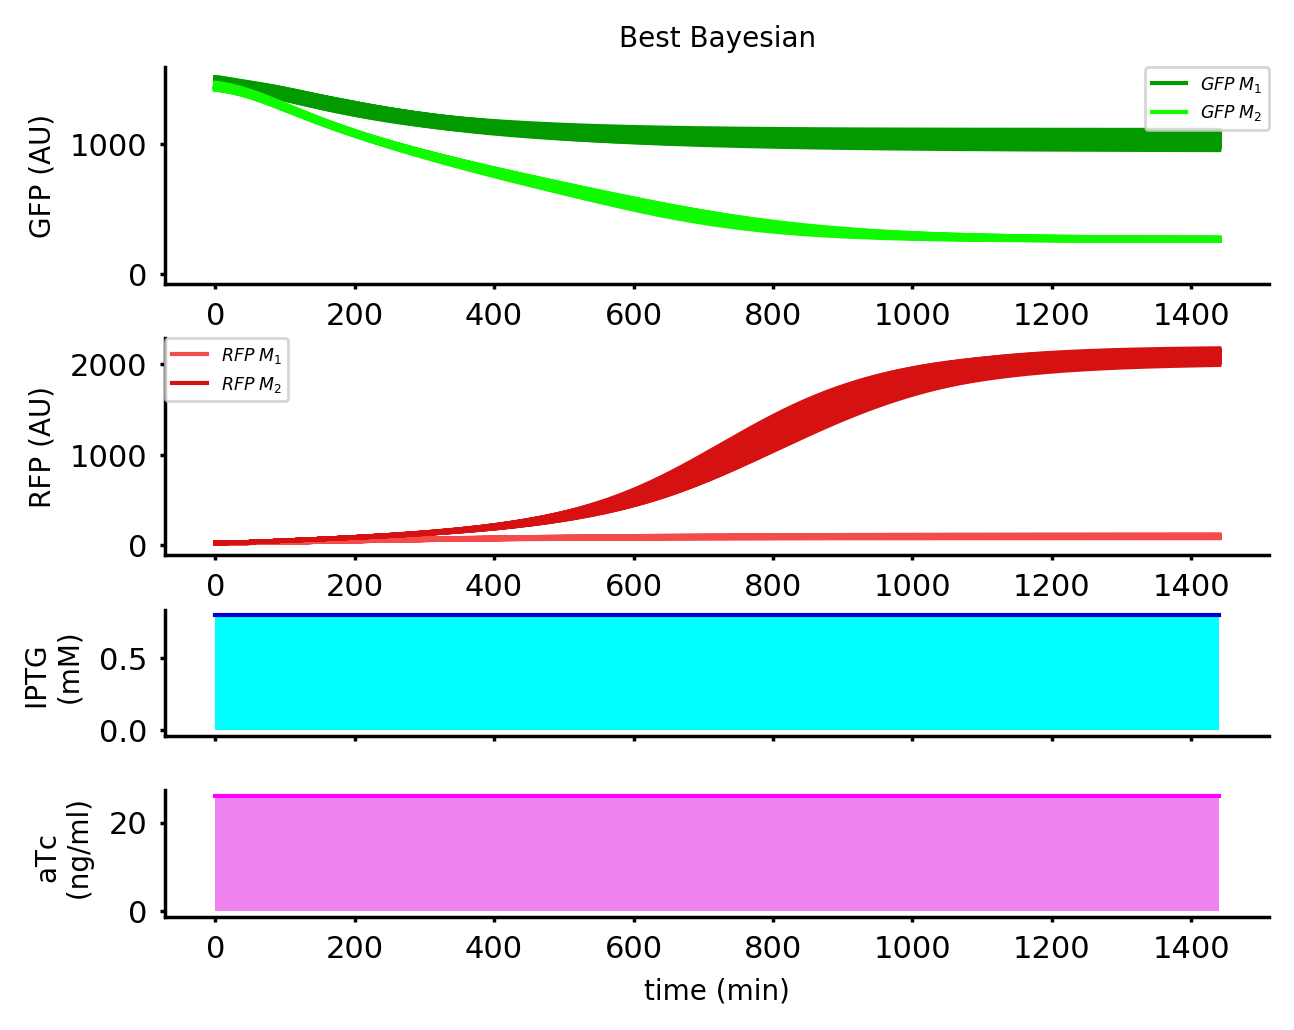

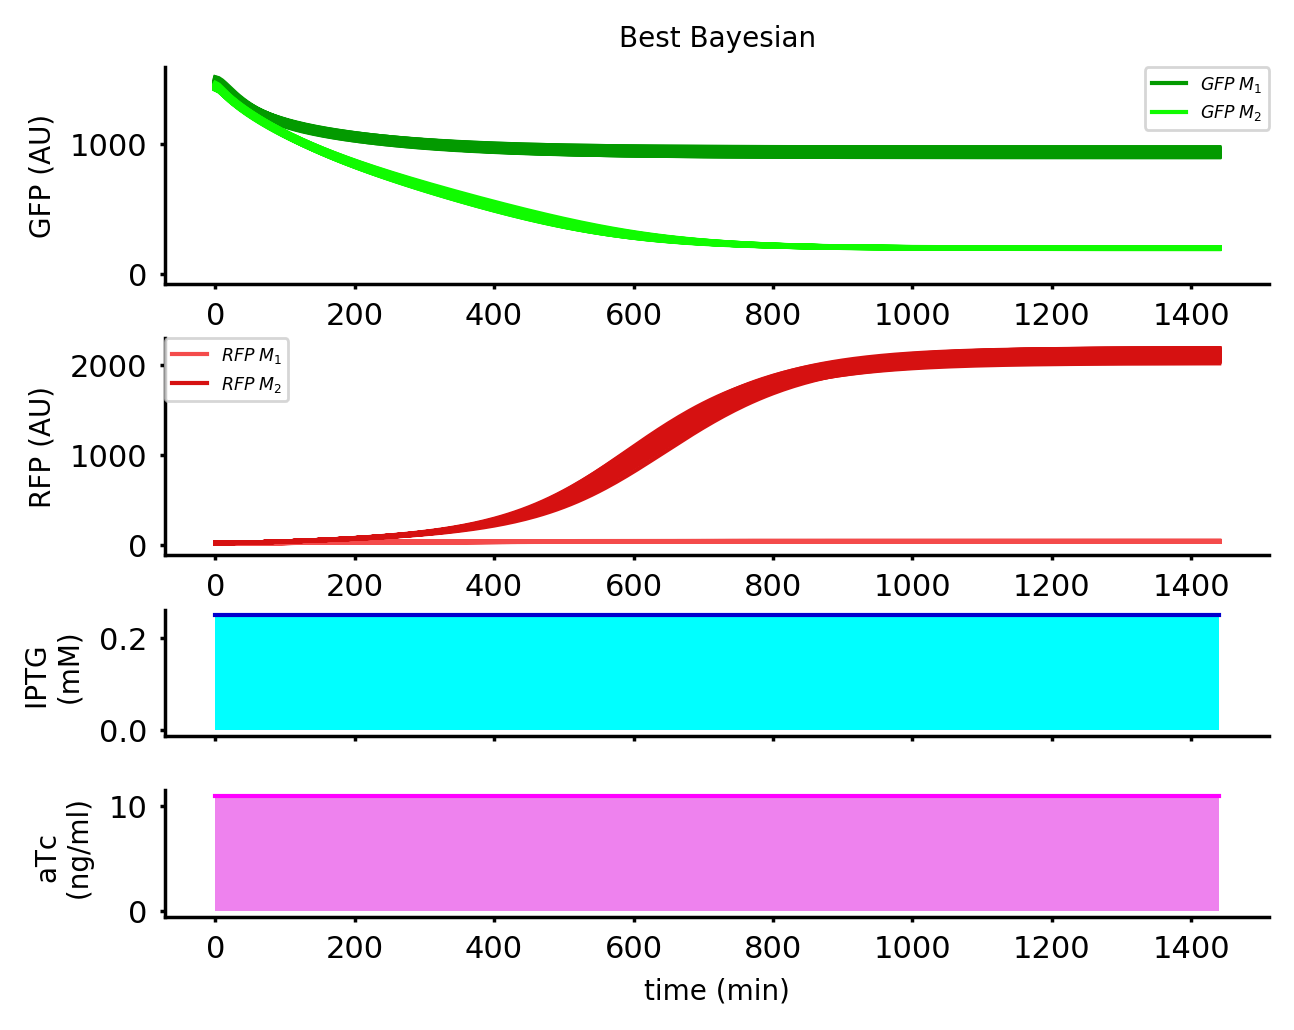

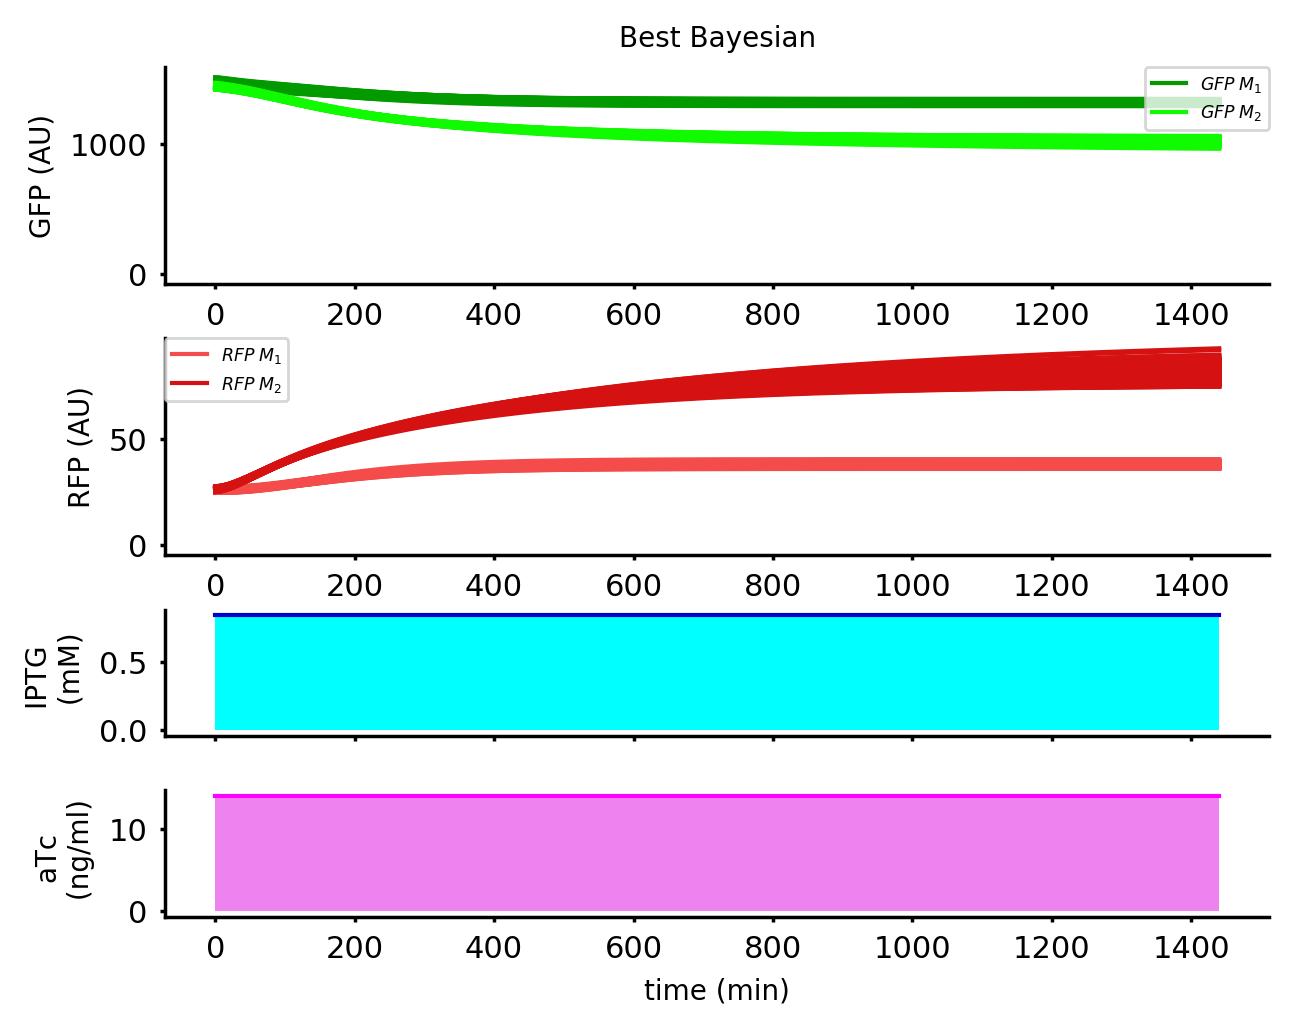

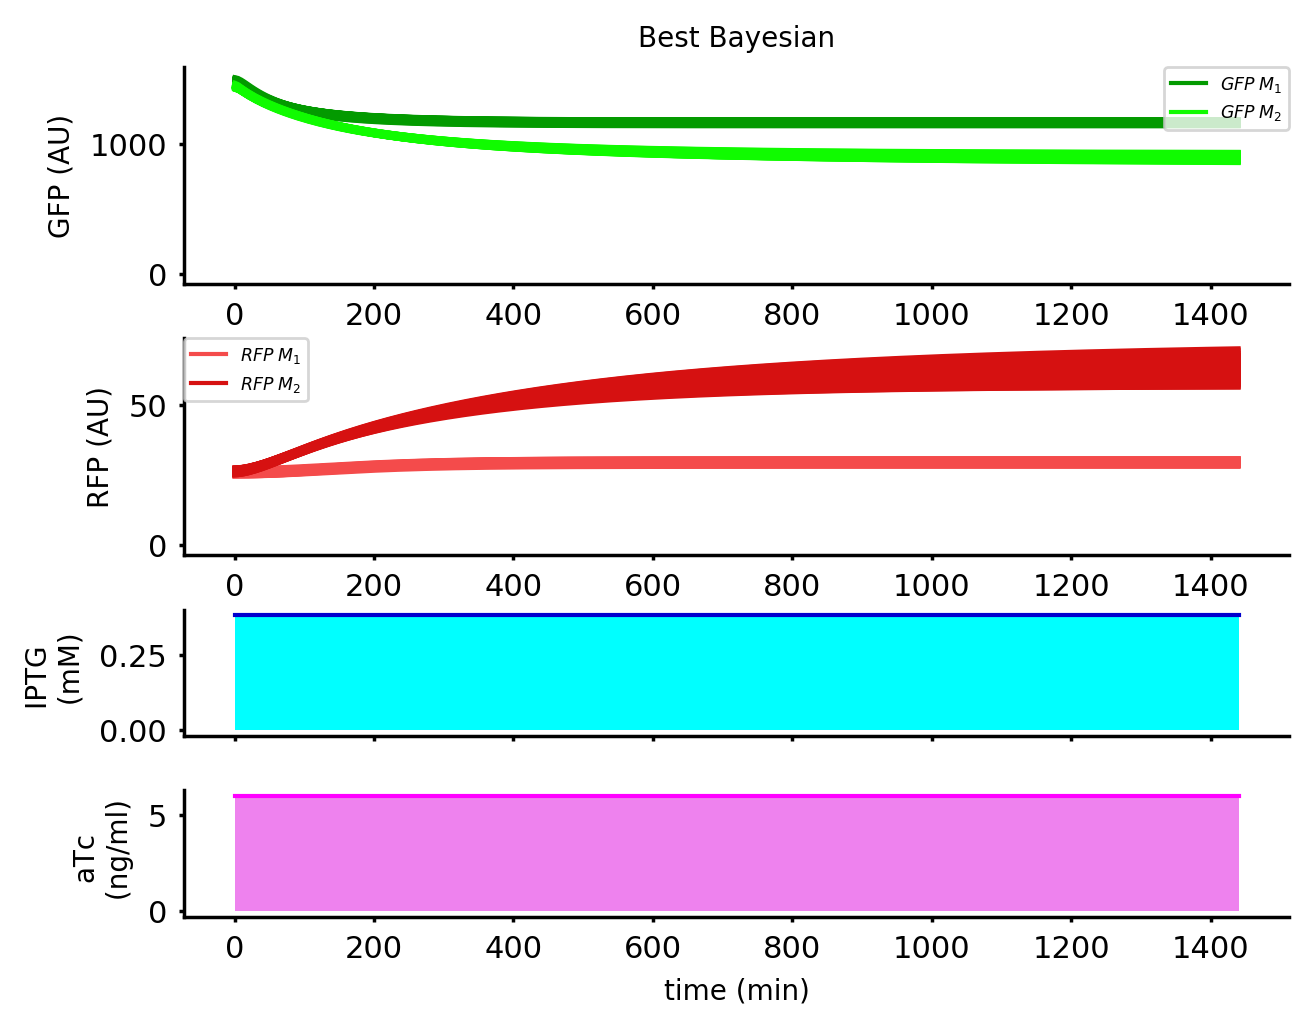

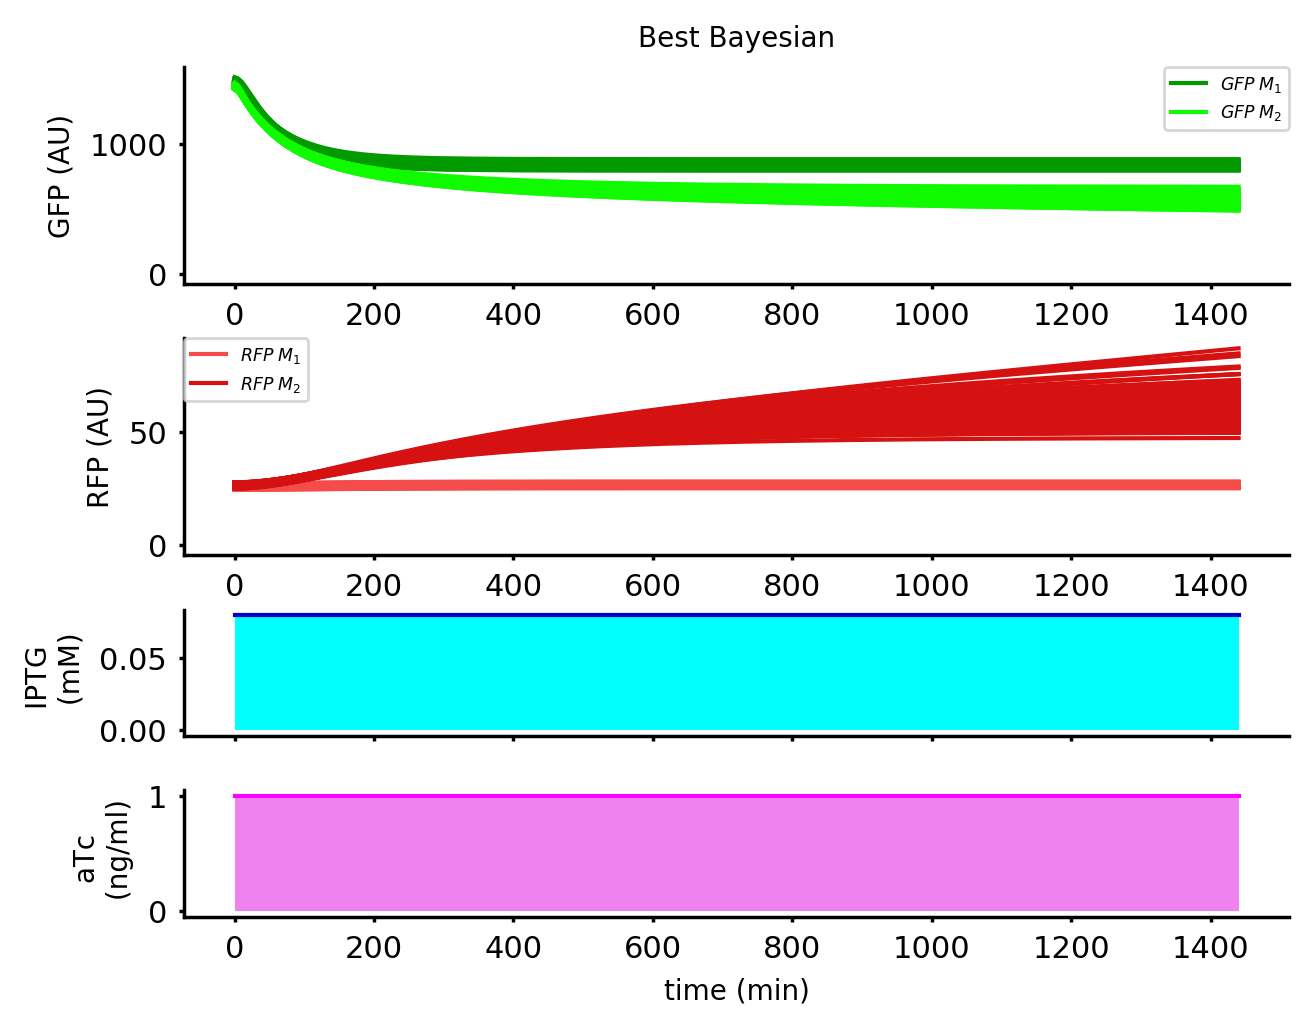

In [17]:
for exp in range(0,9):

    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    sp = [int(i) for i in list(np.linspace(0,(24*60),2))]
    t =  np.linspace(0,(24*60),(24*60)+1)

    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

    # Simulation of the system for the two models and extract of results
    if __name__ ==  '__main__': 
        num_processors = mp.cpu_count()
        p=Pool(processes = num_processors)
        for i in range(0,2):
            if i==0:
                r1 = p.apply_async(SAC.solveALLCy2, args=(t, pM1, sp, ranInput[exp], ivss, pre, 'M1'))
            elif i==1:
                r2 = p.apply_async(SAC.solveALLCy2, args=(t, pM2, sp, ranInput[exp], ivss, pre, 'M2'))

        p.close()
        p.join() 

    solM1 = r1.get()
    solM2 = r2.get()    

    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]

    t =  np.linspace(0,(24*60),round(24*60/5)+1)



    fig = plt.figure(figsize=(5.7, 4.5), dpi = 250)
    sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8,"axes.tickslabelssize":8,"text.usetex" : True,"text.latex.unicode" : True})  
    gs = gridspec.GridSpec(10, 1, hspace = 1.5)

    ax1 = plt.subplot(gs[0:3, 0:2])
    lines1 = ax1.plot(t, GFP_M1,color='#039a00')
    ax1.plot(0,0,color='#039a00', label = '$GFP \; M_{1}$')
    lines2 = ax1.plot(t, GFP_M2, color='#10fb00')
    ax1.plot(0,0,color='#10fb00', label = '$GFP \; M_{2}$')
    ax1.tick_params(length=1.5)
    ax1.set_ylabel('GFP (AU)')
    ax1.set_xlabel('time (min)')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlabel('')
    ax1.set_title('Best Bayesian')


    ax2 = plt.subplot(gs[3:6, 0:2])
    lines1 = ax2.plot(t, RFP_M1,color='#f44b4b')
    ax2.plot(0,0,color='#f44b4b', label = '$RFP \; M_{1}$')
    lines2 = ax2.plot(t, RFP_M2, color='#d61111')
    ax2.plot(0,0,color='#d61111', label = '$RFP \; M_{2}$')
    ax2.tick_params(length=1.5)
    ax2.set_ylabel('RFP (AU)')
    ax2.set_xlabel('time (min)')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlabel('')



    ax3 = plt.subplot(gs[6:8, 0:2])
    ax3.step(sp, [ranInput[exp][0], ranInput[exp][0]], 'mediumblue')
    ax3.fill_between(sp, np.zeros(len(sp)), 
                     [ranInput[exp][0], ranInput[exp][0]],facecolor='cyan')
    ax3.set_xticklabels('')
    ax3.set_ylabel('IPTG \n (mM)')
    ax3.tick_params(length=1.5)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
#     ax3.set_ylim((0, 0.5))


    ax4 = plt.subplot(gs[8:10, 0:2])
    ax4.step(sp, [ranInput[exp][1], ranInput[exp][1], ], 'fuchsia')
    ax4.fill_between(sp, np.zeros(len(sp)), 
                     [ranInput[exp][1], ranInput[exp][1]],facecolor='violet')
    ax4.set_xlabel('time (min)')
    ax4.set_ylabel('aTc \n (ng/ml)')
    ax4.tick_params(length=1.5)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)

    # ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.legend(loc=1, borderaxespad=0., prop={'size': 5})
    ax2.legend(loc=2, borderaxespad=0., prop={'size': 5})
    plt.show()
    fig.savefig('BistabilityAnalysis\AverageBayesianOptimisationRandomSimulation'+str(exp+1)+'.png')

### Simulations Half bistable

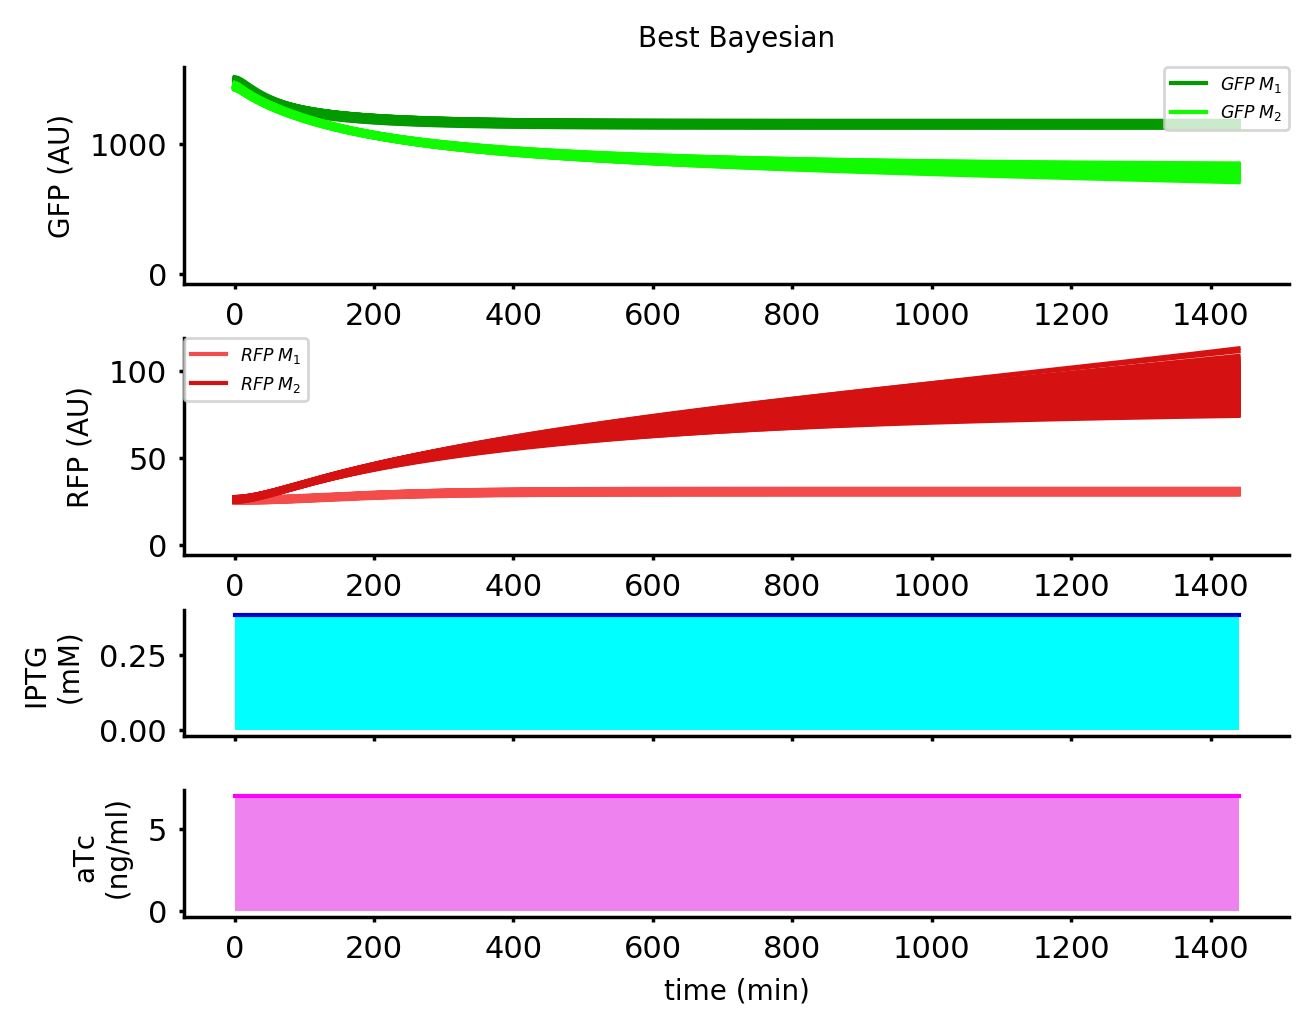

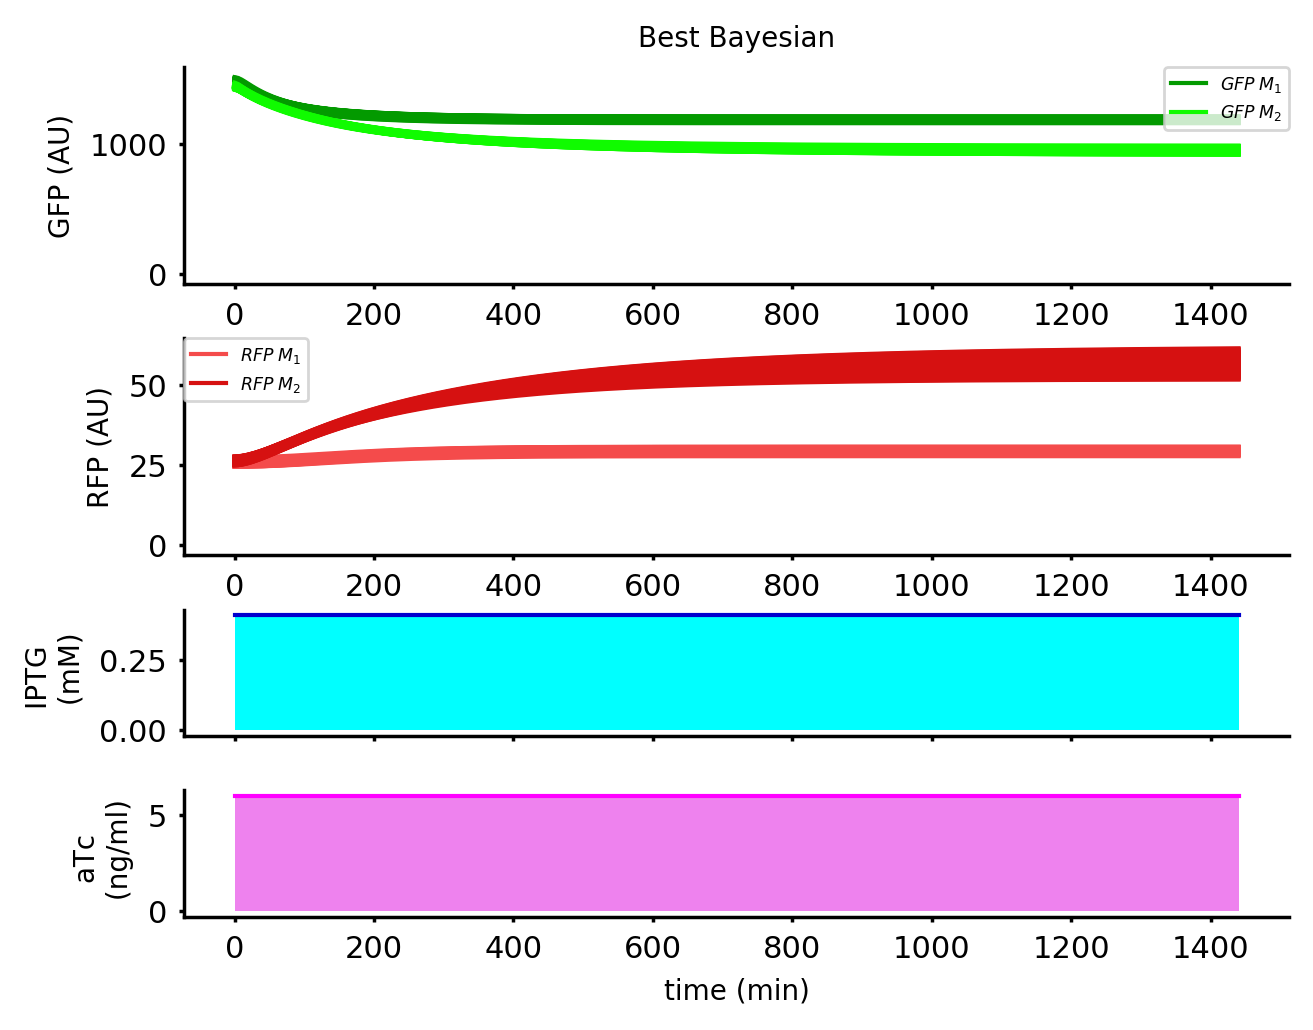

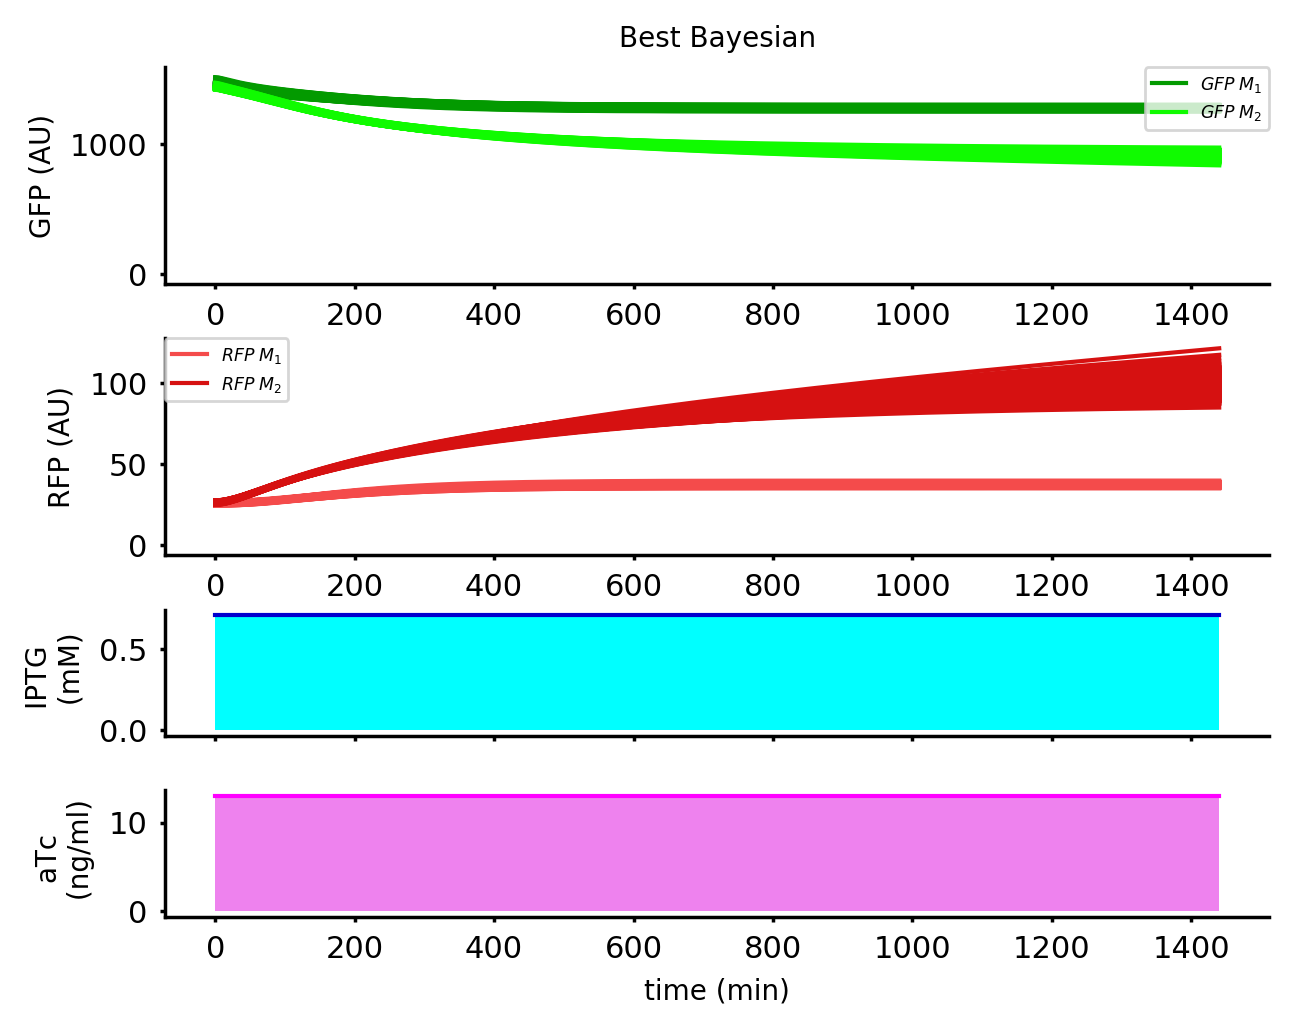

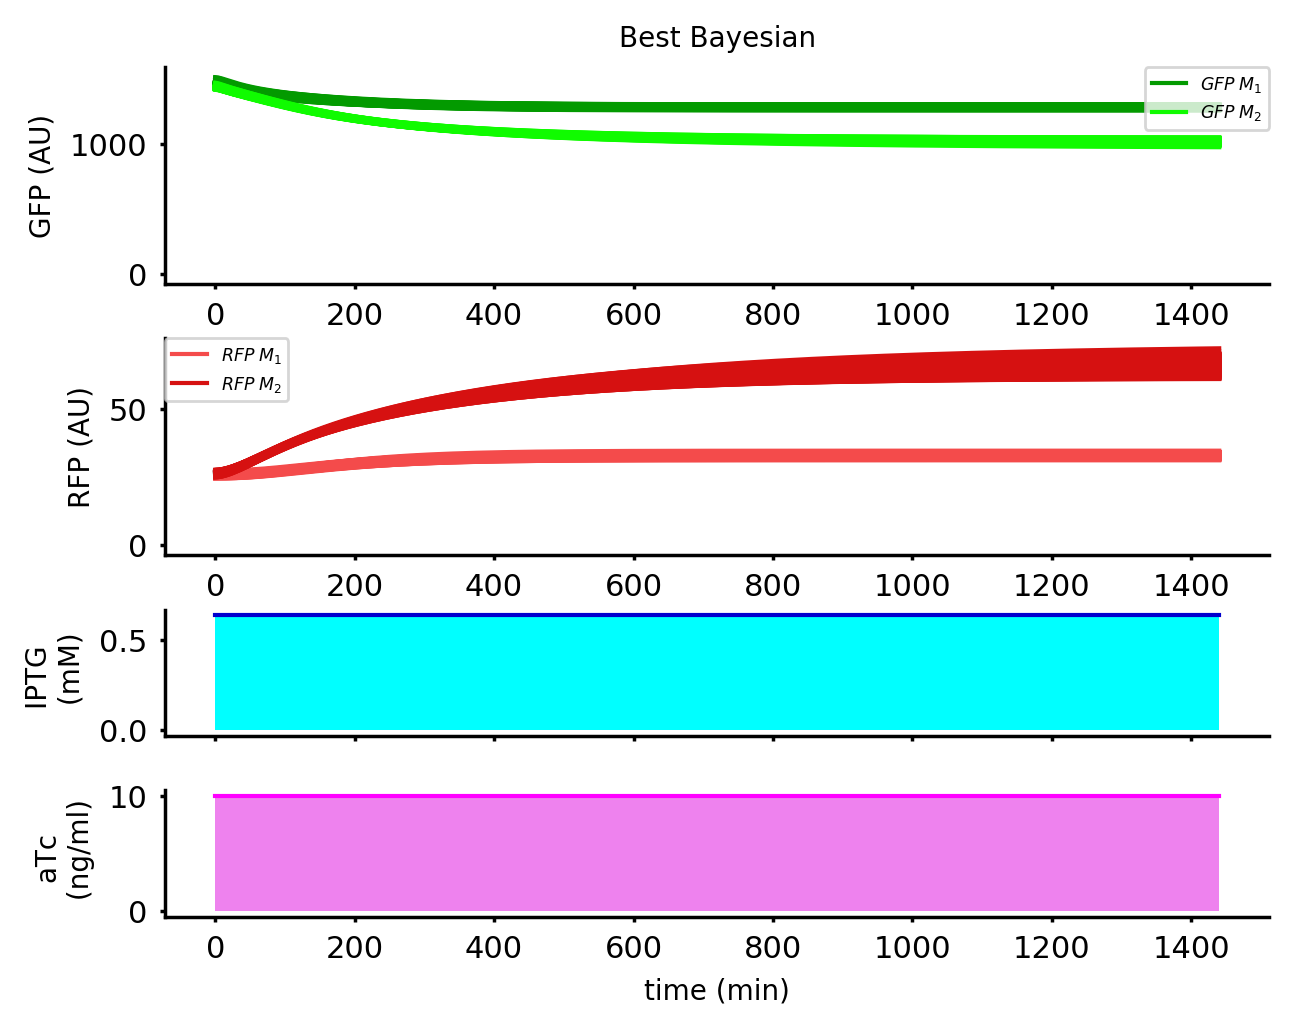

IndexError: list index out of range

In [6]:
for exp in range(0,4):

    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    sp = [int(i) for i in list(np.linspace(0,(24*60),2))]
    t =  np.linspace(0,(24*60),(24*60)+1)

    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

    # Simulation of the system for the two models and extract of results
    if __name__ ==  '__main__': 
        num_processors = mp.cpu_count()
        p=Pool(processes = num_processors)
        for i in range(0,2):
            if i==0:
                r1 = p.apply_async(SAC.solveALLCy2, args=(t, pM1, sp, halfbi[exp], ivss, pre, 'M1'))
            elif i==1:
                r2 = p.apply_async(SAC.solveALLCy2, args=(t, pM2, sp, halfbi[exp], ivss, pre, 'M2'))

        p.close()
        p.join() 

    solM1 = r1.get()
    solM2 = r2.get()    

    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]

    t =  np.linspace(0,(24*60),round(24*60/5)+1)



    fig = plt.figure(figsize=(5.7, 4.5), dpi = 250)
    sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8,"axes.tickslabelssize":8,"text.usetex" : True,"text.latex.unicode" : True})  
    gs = gridspec.GridSpec(10, 1, hspace = 1.5)

    ax1 = plt.subplot(gs[0:3, 0:2])
    lines1 = ax1.plot(t, GFP_M1,color='#039a00')
    ax1.plot(0,0,color='#039a00', label = '$GFP \; M_{1}$')
    lines2 = ax1.plot(t, GFP_M2, color='#10fb00')
    ax1.plot(0,0,color='#10fb00', label = '$GFP \; M_{2}$')
    ax1.tick_params(length=1.5)
    ax1.set_ylabel('GFP (AU)')
    ax1.set_xlabel('time (min)')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlabel('')
    ax1.set_title('Best Bayesian')


    ax2 = plt.subplot(gs[3:6, 0:2])
    lines1 = ax2.plot(t, RFP_M1,color='#f44b4b')
    ax2.plot(0,0,color='#f44b4b', label = '$RFP \; M_{1}$')
    lines2 = ax2.plot(t, RFP_M2, color='#d61111')
    ax2.plot(0,0,color='#d61111', label = '$RFP \; M_{2}$')
    ax2.tick_params(length=1.5)
    ax2.set_ylabel('RFP (AU)')
    ax2.set_xlabel('time (min)')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlabel('')



    ax3 = plt.subplot(gs[6:8, 0:2])
    ax3.step(sp, [halfbi[exp][0], halfbi[exp][0]], 'mediumblue')
    ax3.fill_between(sp, np.zeros(len(sp)), 
                     [halfbi[exp][0], halfbi[exp][0]],facecolor='cyan')
    ax3.set_xticklabels('')
    ax3.set_ylabel('IPTG \n (mM)')
    ax3.tick_params(length=1.5)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
#     ax3.set_ylim((0, 0.5))


    ax4 = plt.subplot(gs[8:10, 0:2])
    ax4.step(sp, [halfbi[exp][1], halfbi[exp][1], ], 'fuchsia')
    ax4.fill_between(sp, np.zeros(len(sp)), 
                     [halfbi[exp][1], halfbi[exp][1]],facecolor='violet')
    ax4.set_xlabel('time (min)')
    ax4.set_ylabel('aTc \n (ng/ml)')
    ax4.tick_params(length=1.5)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)

    # ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.legend(loc=1, borderaxespad=0., prop={'size': 5})
    ax2.legend(loc=2, borderaxespad=0., prop={'size': 5})
    plt.show()
    fig.savefig('BistabilityAnalysis\AverageBayesianOptimisationRandomSimulationHB'+str(exp+1)+'.png')

### Utility Function

In [6]:
ranres = np.zeros(9)

In [7]:
for j in range(0,9):
    if ranres[j]==0:
        u1 = utility1(ranInput[j][0], ranInput[j][1])
        ranres[j] = u1
ranres

E:\UNI\C_Drive\eigg.sms.ed.ac.uk\BayesianOptimisation\CompareAMIGOvsBAYES\BhattacharyyaDistanceV1.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  st = dE/np.sqrt(abs(np.linalg.det(sd1))*abs(np.linalg.det(sd2)))


array([3.95361700e+04, 9.82495075e+03, 1.09881150e+05, 1.36266149e+05,
       7.86583083e+06, 1.66595551e+07, 1.32454434e+04, 1.08920356e+04,
       3.83564862e+05])

In [154]:
for j in range(0,9):
    if ranres[j]==float('inf'):
        u1 = utility1(ranInput[j][0], ranInput[j][1])
        ranres[j] = u1
ranres

array([1.46315371e+10, 5.18693969e+07, 2.05080950e+08, 1.96806491e+08,
       3.90216134e+13, 1.07452190e+14, 1.87956684e+10, 1.30475577e+10,
       4.53894192e+10])

In [8]:
df = pd.DataFrame({"RandomUtility": [ranres]})
df.to_pickle('BistabilityAnalysis\RandomUtilityRFP.pkl')

In [7]:
df = pd.read_pickle('BistabilityAnalysis\RandomUtilityRFP.pkl')

In [12]:
ranres = df['RandomUtility'][0]

In [9]:
halres = np.zeros(4)

In [10]:
for j in range(0,4):
    if halres[j]==0:
        u1 = utility1(halfbi[j][0], halfbi[j][1])
        halres[j] = u1
halres

array([1132014.17290084,   12940.05237019,   11797.94781894,
         15185.22894634])

In [11]:
df = pd.DataFrame({"HalfBistUtility": [halres]})
df.to_pickle('BistabilityAnalysis\HalfBistUtilityRFP.pkl')

In [ ]:
df = pd.read_pickle('BistabilityAnalysis\HalfBistUtilityRFP.pkl')
halres = df['HalfBistUtility'][0]

### Optimal Input

In [13]:
optimizerM1 = pickle.load( open( "E:/UNI/C_Drive/eigg.sms.ed.ac.uk/BayesianOptimisation/CompareAMIGOvsBAYES/config2sRFP1.optim", "rb" ) )
optimizerM2 = pickle.load( open( "E:/UNI/C_Drive/eigg.sms.ed.ac.uk/BayesianOptimisation/CompareAMIGOvsBAYES/config2sRFP2.optim", "rb" ) )

In [14]:
OEDinput = [[round(optimizerM2.max['params']['IPTG1'],2)+1e-7, int(optimizerM2.max['params']['aTc1'])+1e-7],
            [round(optimizerM2.max['params']['IPTG2'],2)+1e-7, int(optimizerM2.max['params']['aTc2'])+1e-7]]

#### Decomposed

Simulations

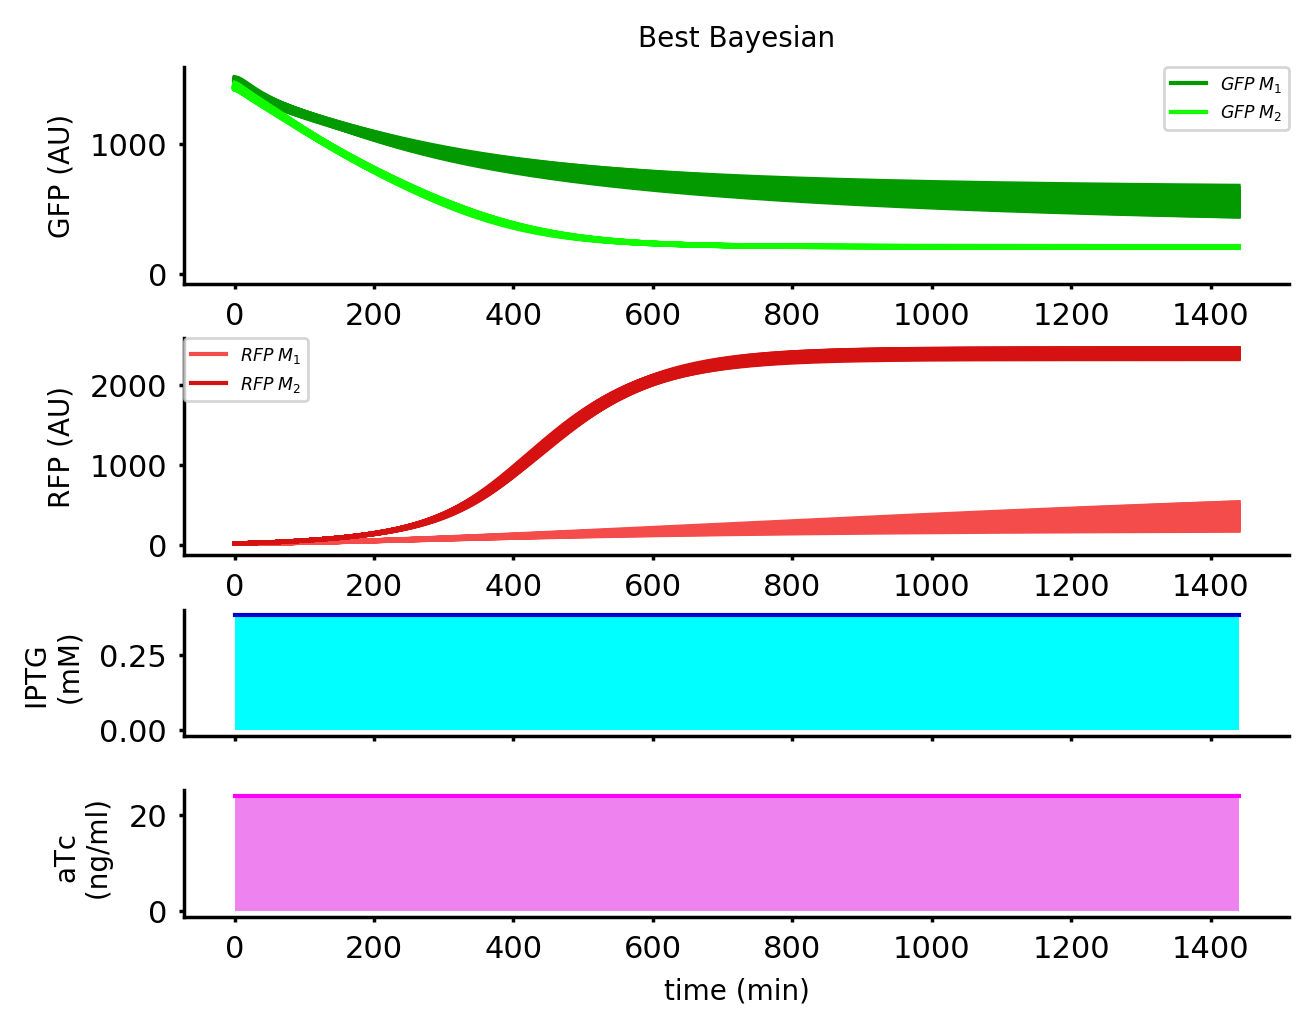

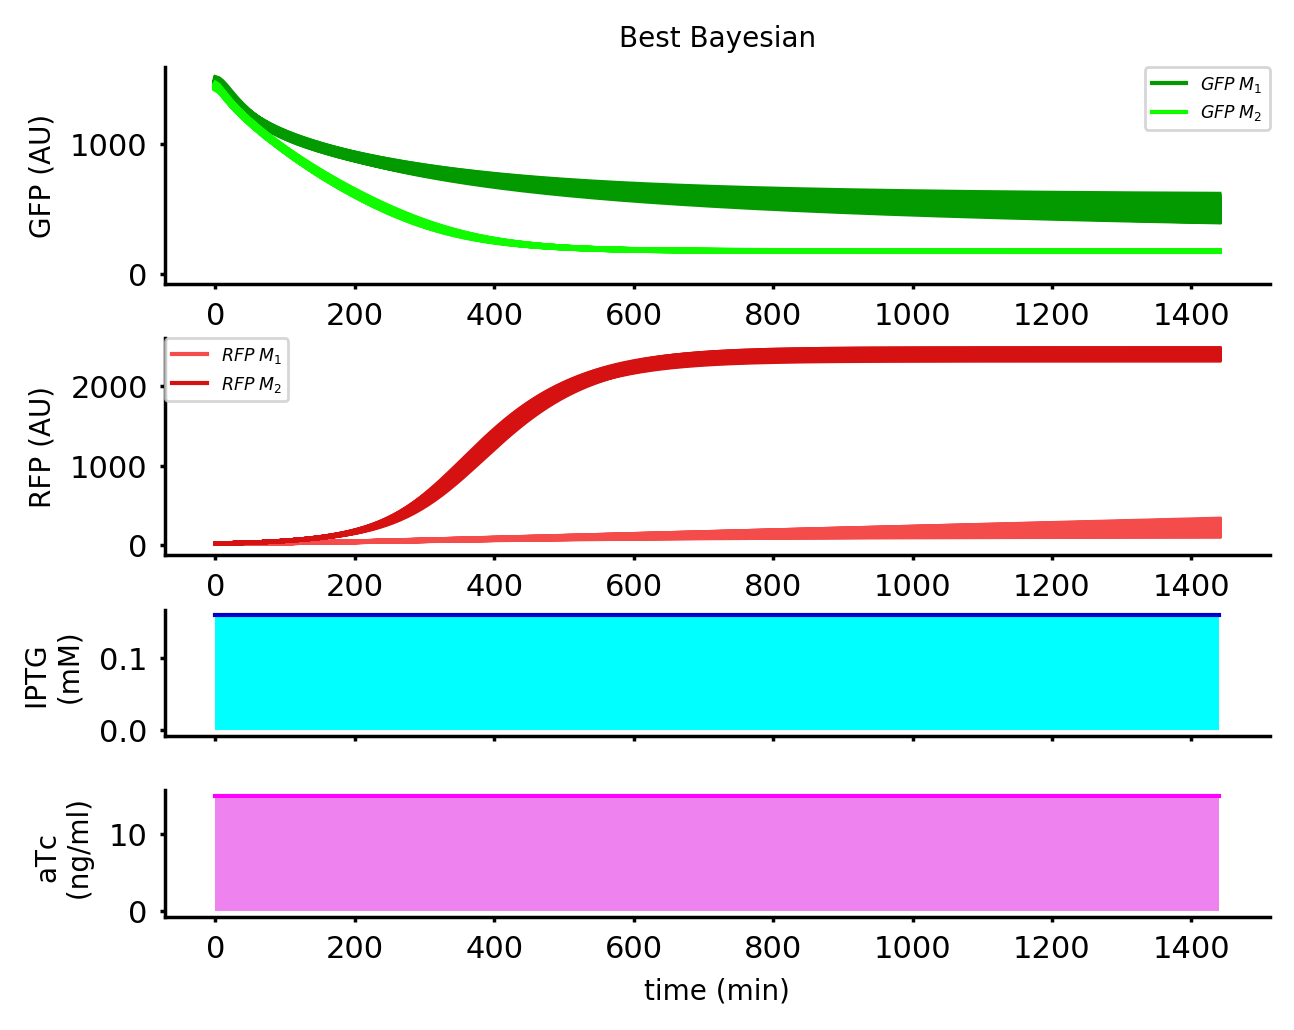

In [15]:
for exp in range(0,2):

    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    sp = [int(i) for i in list(np.linspace(0,(24*60),2))]
    t =  np.linspace(0,(24*60),(24*60)+1)

    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

    # Simulation of the system for the two models and extract of results
    if __name__ ==  '__main__': 
        num_processors = mp.cpu_count()
        p=Pool(processes = num_processors)
        for i in range(0,2):
            if i==0:
                r1 = p.apply_async(SAC.solveALLCy2, args=(t, pM1, sp, OEDinput[exp], ivss, pre, 'M1'))
            elif i==1:
                r2 = p.apply_async(SAC.solveALLCy2, args=(t, pM2, sp, OEDinput[exp], ivss, pre, 'M2'))

        p.close()
        p.join() 

    solM1 = r1.get()
    solM2 = r2.get()    

    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]

    t =  np.linspace(0,(24*60),round(24*60/5)+1)



    fig = plt.figure(figsize=(5.7, 4.5), dpi = 250)
    sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8,"axes.tickslabelssize":8,"text.usetex" : True,"text.latex.unicode" : True})  
    gs = gridspec.GridSpec(10, 1, hspace = 1.5)

    ax1 = plt.subplot(gs[0:3, 0:2])
    lines1 = ax1.plot(t, GFP_M1,color='#039a00')
    ax1.plot(0,0,color='#039a00', label = '$GFP \; M_{1}$')
    lines2 = ax1.plot(t, GFP_M2, color='#10fb00')
    ax1.plot(0,0,color='#10fb00', label = '$GFP \; M_{2}$')
    ax1.tick_params(length=1.5)
    ax1.set_ylabel('GFP (AU)')
    ax1.set_xlabel('time (min)')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlabel('')
    ax1.set_title('Best Bayesian')


    ax2 = plt.subplot(gs[3:6, 0:2])
    lines1 = ax2.plot(t, RFP_M1,color='#f44b4b')
    ax2.plot(0,0,color='#f44b4b', label = '$RFP \; M_{1}$')
    lines2 = ax2.plot(t, RFP_M2, color='#d61111')
    ax2.plot(0,0,color='#d61111', label = '$RFP \; M_{2}$')
    ax2.tick_params(length=1.5)
    ax2.set_ylabel('RFP (AU)')
    ax2.set_xlabel('time (min)')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlabel('')



    ax3 = plt.subplot(gs[6:8, 0:2])
    ax3.step(sp, [OEDinput[exp][0], OEDinput[exp][0]], 'mediumblue')
    ax3.fill_between(sp, np.zeros(len(sp)), 
                     [OEDinput[exp][0], OEDinput[exp][0]],facecolor='cyan')
    ax3.set_xticklabels('')
    ax3.set_ylabel('IPTG \n (mM)')
    ax3.tick_params(length=1.5)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
#     ax3.set_ylim((0, 0.5))


    ax4 = plt.subplot(gs[8:10, 0:2])
    ax4.step(sp, [OEDinput[exp][1], OEDinput[exp][1], ], 'fuchsia')
    ax4.fill_between(sp, np.zeros(len(sp)), 
                     [OEDinput[exp][1], OEDinput[exp][1]],facecolor='violet')
    ax4.set_xlabel('time (min)')
    ax4.set_ylabel('aTc \n (ng/ml)')
    ax4.tick_params(length=1.5)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)

    # ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.legend(loc=1, borderaxespad=0., prop={'size': 5})
    ax2.legend(loc=2, borderaxespad=0., prop={'size': 5})
    plt.show()
#     fig.savefig('BistabilityAnalysis\BayesianOptimisationOEDDecomposedSimulation'+str(exp+1)+'.png')

In [16]:
decres = np.zeros(2)

In [17]:
for j in range(0,2):
    if decres[j]==0:
        u1 = utility1(OEDinput[j][0], OEDinput[j][1])
        decres[j] = u1
decres

array([20055652.09829246, 23103040.28381877])

In [18]:
df = pd.DataFrame({"DecompOEDUtility": [decres]})
df.to_pickle('BistabilityAnalysis\DecompUtilityRFP.pkl')

In [21]:
df = pd.read_pickle('BistabilityAnalysis\DecompUtilityRFP.pkl')
decres = df['DecompOEDUtility'][0]

#### Together

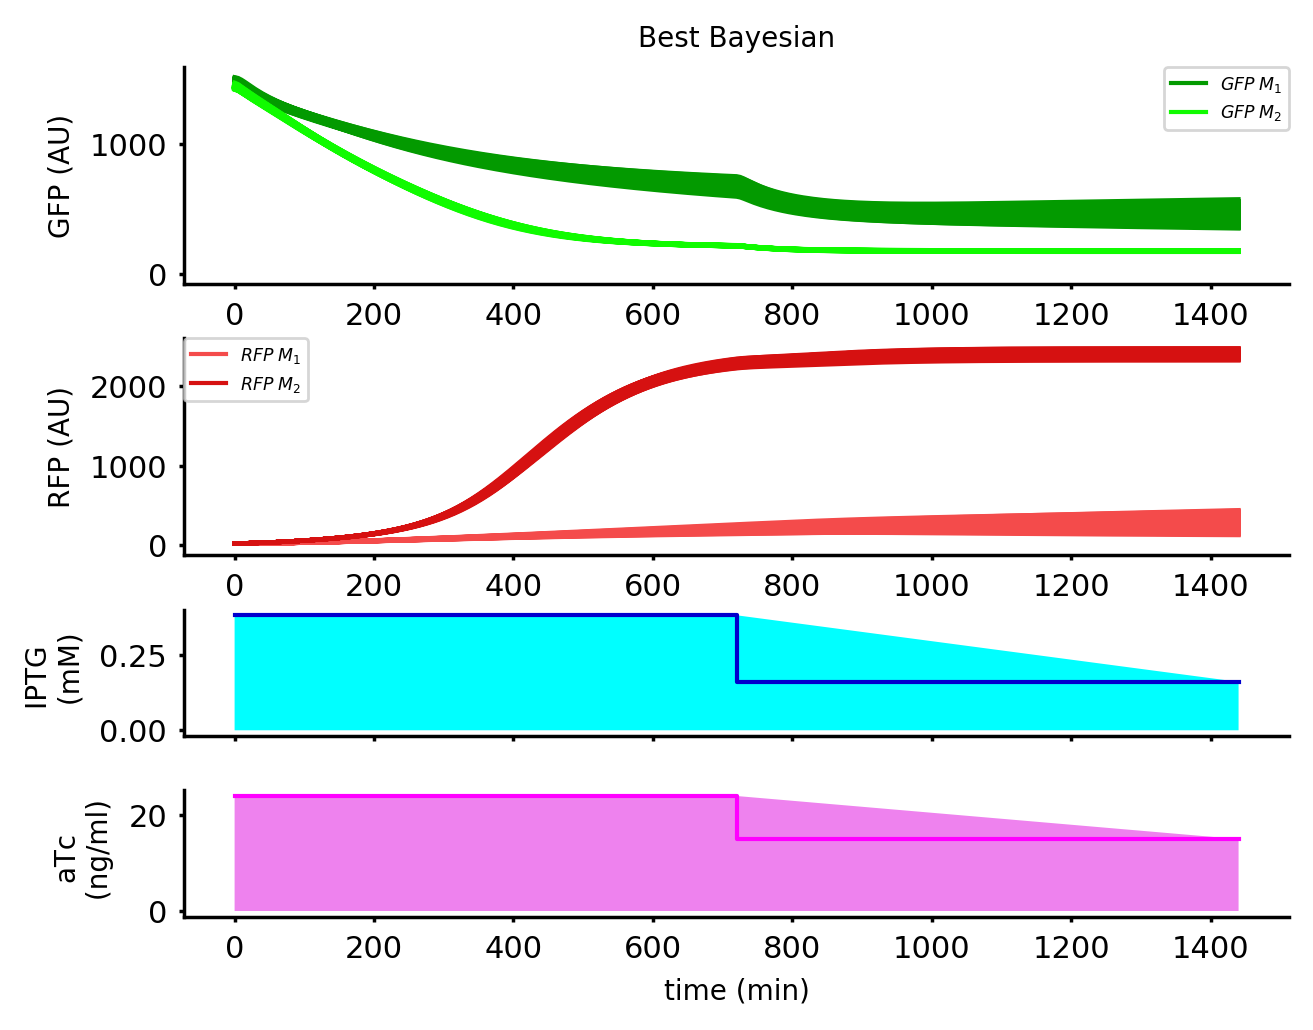

In [19]:
for exp in range(0,1):

    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    sp = [int(i) for i in list(np.linspace(0,(24*60),3))]
    t =  np.linspace(0,(24*60),(24*60)+1)

    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

    # Simulation of the system for the two models and extract of results
    if __name__ ==  '__main__': 
        num_processors = mp.cpu_count()
        p=Pool(processes = num_processors)
        for i in range(0,2):
            if i==0:
                r1 = p.apply_async(SAC.solveALLCy2, args=(t, pM1, sp, [OEDinput[exp][0], OEDinput[exp][1], OEDinput[exp+1][0], OEDinput[exp+1][1]], ivss, pre, 'M1'))
            elif i==1:
                r2 = p.apply_async(SAC.solveALLCy2, args=(t, pM2, sp, [OEDinput[exp][0], OEDinput[exp][1], OEDinput[exp+1][0], OEDinput[exp+1][1]], ivss, pre, 'M2'))

        p.close()
        p.join() 

    solM1 = r1.get()
    solM2 = r2.get()    

    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]

    t =  np.linspace(0,(24*60),round(24*60/5)+1)



    fig = plt.figure(figsize=(5.7, 4.5), dpi = 250)
    sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8,"axes.tickslabelssize":8,"text.usetex" : True,"text.latex.unicode" : True})  
    gs = gridspec.GridSpec(10, 1, hspace = 1.5)

    ax1 = plt.subplot(gs[0:3, 0:2])
    lines1 = ax1.plot(t, GFP_M1,color='#039a00')
    ax1.plot(0,0,color='#039a00', label = '$GFP \; M_{1}$')
    lines2 = ax1.plot(t, GFP_M2, color='#10fb00')
    ax1.plot(0,0,color='#10fb00', label = '$GFP \; M_{2}$')
    ax1.tick_params(length=1.5)
    ax1.set_ylabel('GFP (AU)')
    ax1.set_xlabel('time (min)')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlabel('')
    ax1.set_title('Best Bayesian')


    ax2 = plt.subplot(gs[3:6, 0:2])
    lines1 = ax2.plot(t, RFP_M1,color='#f44b4b')
    ax2.plot(0,0,color='#f44b4b', label = '$RFP \; M_{1}$')
    lines2 = ax2.plot(t, RFP_M2, color='#d61111')
    ax2.plot(0,0,color='#d61111', label = '$RFP \; M_{2}$')
    ax2.tick_params(length=1.5)
    ax2.set_ylabel('RFP (AU)')
    ax2.set_xlabel('time (min)')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlabel('')



    ax3 = plt.subplot(gs[6:8, 0:2])
    ax3.step(sp, [OEDinput[exp][0], OEDinput[exp][0], OEDinput[exp+1][0]], 'mediumblue')
    ax3.fill_between(sp, np.zeros(len(sp)), 
                     [OEDinput[exp][0], OEDinput[exp][0], OEDinput[exp+1][0]],facecolor='cyan')
    ax3.set_xticklabels('')
    ax3.set_ylabel('IPTG \n (mM)')
    ax3.tick_params(length=1.5)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
#     ax3.set_ylim((0, 0.5))


    ax4 = plt.subplot(gs[8:10, 0:2])
    ax4.step(sp, [OEDinput[exp][1], OEDinput[exp][1], OEDinput[exp+1][1] ], 'fuchsia')
    ax4.fill_between(sp, np.zeros(len(sp)), 
                     [OEDinput[exp][1], OEDinput[exp][1], OEDinput[exp+1][1]],facecolor='violet')
    ax4.set_xlabel('time (min)')
    ax4.set_ylabel('aTc \n (ng/ml)')
    ax4.tick_params(length=1.5)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)

    # ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.legend(loc=1, borderaxespad=0., prop={'size': 5})
    ax2.legend(loc=2, borderaxespad=0., prop={'size': 5})
    plt.show()
#     fig.savefig('BistabilityAnalysis\BayesianOptimisationOEDBestSimulation'+str(exp+1)+'.png')

In [20]:
bestres = np.zeros(1)

In [21]:
for j in range(0,1):
    if bestres[j]==0:
        u1 = utility2(OEDinput[j][0], OEDinput[j+1][0], OEDinput[j][1], OEDinput[j+1][1])
        bestres[j] = u1
bestres

array([13586002.44934694])

In [22]:
df = pd.DataFrame({"BestOEDUtility": [bestres]})
df.to_pickle('BistabilityAnalysis\BestUtilityRFP.pkl')

In [22]:
df = pd.read_pickle('BistabilityAnalysis\BestUtilityRFP.pkl')
bestres = df['BestOEDUtility'][0]

## Show Utility results

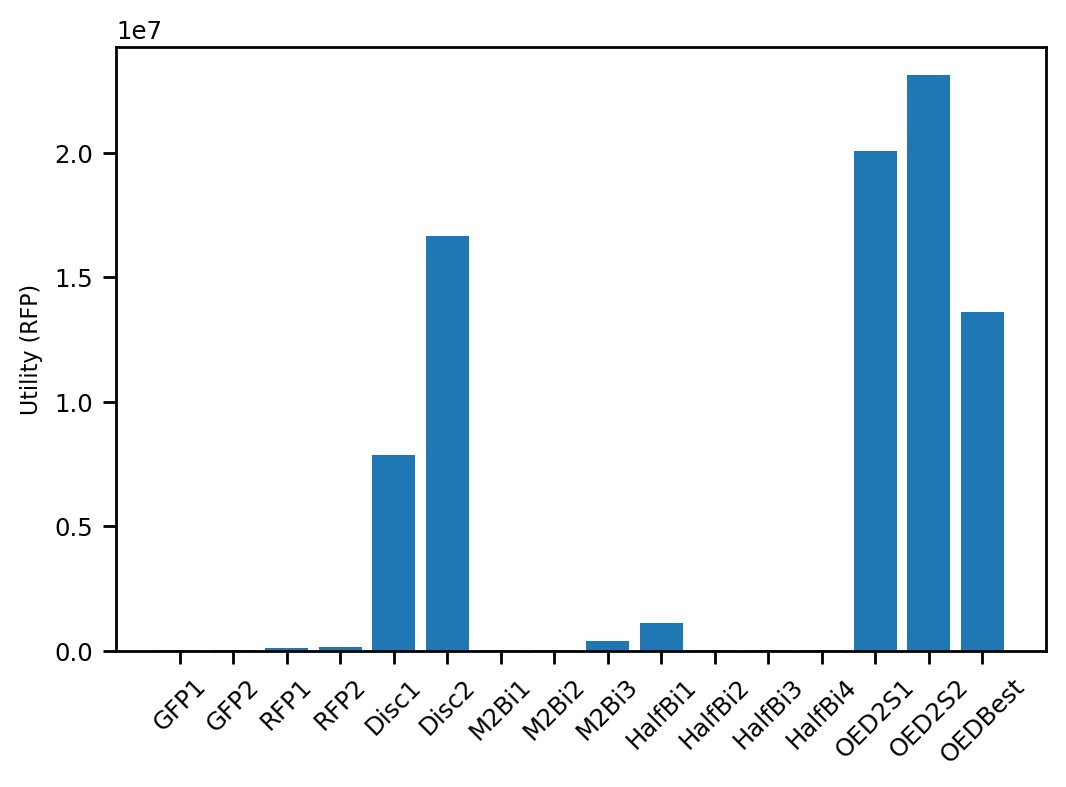

In [23]:
xran1 = np.arange(16)
plt.figure(dpi=200)
plt.bar(xran1, np.concatenate([ranres, halres, decres, bestres]))
plt.xticks(xran1, ('GFP1', 'GFP2', 'RFP1', 'RFP2', 'Disc1', 'Disc2', 'M2Bi1', 'M2Bi2', 'M2Bi3',
                   'HalfBi1', 'HalfBi2', 'HalfBi3', 'HalfBi4', 'OED2S1', 'OED2S2', 'OEDBest'))
# plt.yscale('log')
plt.ylabel('Utility (RFP)')
plt.xticks(rotation=45)
plt.show()

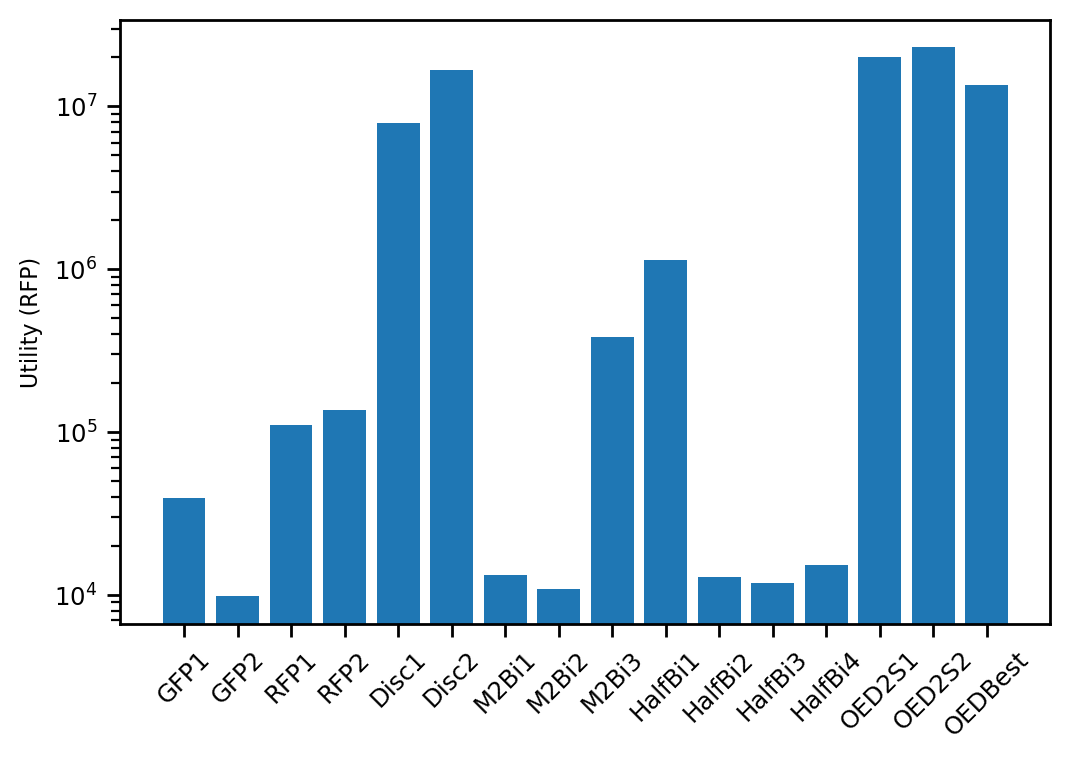

In [24]:
xran1 = np.arange(16)
plt.figure(dpi=200)
plt.bar(xran1, np.concatenate([ranres, halres, decres, bestres]))
plt.xticks(xran1, ('GFP1', 'GFP2', 'RFP1', 'RFP2', 'Disc1', 'Disc2', 'M2Bi1', 'M2Bi2', 'M2Bi3',
                   'HalfBi1', 'HalfBi2', 'HalfBi3', 'HalfBi4', 'OED2S1', 'OED2S2', 'OEDBest'))
plt.yscale('log')
plt.ylabel('Utility (RFP)')
plt.xticks(rotation=45)
plt.show()